In [6]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE, ConvNeXtBlock1D


/home/nwertheim/miniconda3/bin/python


In [7]:
train_file = os.path.join(univariate_data_path, 'merged_univariate_no_PCA_train.npy')
train_data = np.load(train_file, allow_pickle=True)
test_file = os.path.join(univariate_data_path, 'merged_univariate_no_PCA_test.npy')
test_data = np.load(test_file, allow_pickle=True)
print(train_data.shape)
print(test_data.shape)

print(train_data[0]['signal'].shape)
print(train_data[0])



(4003,)
(1171,)
(33060, 1)
{'record_name': 'icehg956-chan0', 'signal': array([[ 3.15229875],
       [ 2.9328331 ],
       [ 2.72123653],
       ...,
       [-0.50077395],
       [-0.52593061],
       [-0.54714237]]), 'metadata': {'fs': 20, 'sig_len': 35460, 'n_sig': 6, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'sig_name': ['S1', 'S1_DOCFILT-4-0.08-5', 'S2', 'S2_DOCFILT-4-0.08-5', 'S3', 'S3_DOCFILT-4-0.08-5'], 'comments': ['Comments:', 'RecID 956', 'RecType Induced', 'Gestation 40', 'Rectime 30.3', 'Age 28', 'Weight 82', 'Placental_position end', 'Height 173', 'Newborn_weight 3350', 'Pair_RecID 958']}}


In [8]:
import numpy as np
import pandas as pd

# Function to create time windows from the signal data
def create_time_windows(data, window_length=12000, step_size=12000):
    """
    Create sliding windows of a specified length and step size from a list of signals.

    Args:
        data: list of dicts, each containing a 'signal' array of shape (seq_len, 1)
        window_length: number of time steps in each window
        step_size: number of time steps to move between windows (for overlap)

    Returns:
        np.ndarray: shape (num_windows, window_length), univariate windows
    """
    windows = []

    for entry in data:
        signal = entry['signal'].flatten()  # shape: (seq_len,)
        signal_length = len(signal)

        if signal_length < window_length:
            continue

        for start_idx in range(0, signal_length - window_length + 1, step_size):
            end_idx = start_idx + window_length
            window = signal[start_idx:end_idx]
            windows.append(window)

    return np.array(windows)  # shape: (num_windows, window_length)


X_train = create_time_windows(train_data)
X_test = create_time_windows(test_data)
print(X_train.shape)
print(X_test.shape)

(9669, 12000)
(3179, 12000)


In [9]:
def mask_data(x, mask_ratio=0.75, patch_size=8):
    """
    Apply patch-based masking to a batch of univariate time series.

    Args:
        x: np.ndarray of shape (num_windows, window_length)
        mask_ratio: float, fraction of patches to mask
        patch_size: int, number of time steps in each patch

    Returns:
        np.ndarray: masked version of x with same shape
    """
    x_masked = np.copy(x)
    num_windows, window_length = x.shape
    num_patches = window_length // patch_size

    for i in range(num_windows):
        mask = np.random.rand(num_patches) < mask_ratio
        for j in range(num_patches):
            if mask[j]:
                start = j * patch_size
                end = (j + 1) * patch_size
                x_masked[i, start:end] = 0  # or np.nan if you prefer

    return x_masked

# Apply masking to train, validation, and test sets
mask_ratio = 0.75  # Adjust this to your desired masking ratio
masked_X_train = mask_data(X_train, mask_ratio)
masked_X_test = mask_data(X_test, mask_ratio)

# Check the shape of the masked datasets
print(f"Masked Training set shape: {masked_X_train.shape}")
print(f"Masked Test set shape: {masked_X_test.shape}")

Masked Training set shape: (9669, 12000)
Masked Test set shape: (3179, 12000)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import optuna
import numpy as np
import joblib
import os

# Ensure you define your FCMAE and any required components above this.

# Example dataset (masked and original inputs)
masked_X_tensor = torch.tensor(masked_X_train, dtype=torch.float32).unsqueeze(1)
original_X_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    # Hyperparameter suggestions
    num_blocks = trial.suggest_int("num_blocks", 2, 5)
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7, 9])
    base_dim = trial.suggest_categorical("base_dim", [32, 64, 128])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []

    print(f"Starting Trial {trial.number}...")

    for fold, (train_idx, val_idx) in enumerate(kf.split(masked_X_tensor)):
        train_dataset = TensorDataset(masked_X_tensor[train_idx], original_X_tensor[train_idx])
        val_dataset = TensorDataset(masked_X_tensor[val_idx], original_X_tensor[val_idx])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = FCMAE(in_channels=1, base_dim=base_dim, num_blocks=num_blocks, kernel_size=kernel_size).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        # Train for a few epochs
        for epoch in range(5):
            model.train()
            for masked_input, original_input in train_loader:
                masked_input = masked_input.to(device)
                original_input = original_input.to(device)

                optimizer.zero_grad()
                reconstructed = model(masked_input)
                loss = criterion(reconstructed, original_input)
                loss.backward()
                optimizer.step()

        # Evaluate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for masked_input, original_input in val_loader:
                masked_input = masked_input.to(device)
                original_input = original_input.to(device)

                reconstructed = model(masked_input)
                loss = criterion(reconstructed, original_input)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        fold_losses.append(avg_val_loss)

        # print(f"  Fold {fold+1} val loss: {avg_val_loss:.4f}")

    mean_val_loss = np.mean(fold_losses)
    print(f"Trial {trial.number} completed - Mean CV Loss: {mean_val_loss:.4f}")
    return mean_val_loss

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

# Print best result
print("Best trial:")
print(study.best_trial)

# Save the Optuna study
path = os.path.join(models_path, "fcmae_optuna_no_PCA_normalized_correct.pkl")
joblib.dump(study, path)
print(f"Saved Optuna study to {path}")


[I 2025-05-06 11:57:48,555] A new study created in memory with name: no-name-981b709b-bcd4-4b0a-8d5d-c09c7963a24c


Starting Trial 0...


[I 2025-05-06 11:58:55,947] Trial 0 finished with value: 0.021203568774806565 and parameters: {'num_blocks': 5, 'kernel_size': 7, 'base_dim': 32, 'learning_rate': 0.00016938000495408888, 'batch_size': 16}. Best is trial 0 with value: 0.021203568774806565.


Trial 0 completed - Mean CV Loss: 0.0212
Starting Trial 1...


[I 2025-05-06 12:00:46,720] Trial 1 finished with value: 0.44180619561475176 and parameters: {'num_blocks': 3, 'kernel_size': 3, 'base_dim': 128, 'learning_rate': 1.0286270172697185e-05, 'batch_size': 16}. Best is trial 0 with value: 0.021203568774806565.


Trial 1 completed - Mean CV Loss: 0.4418
Starting Trial 2...


/scratch-local/nwertheim.11583483/ipykernel_3792452/380387742.py:13: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


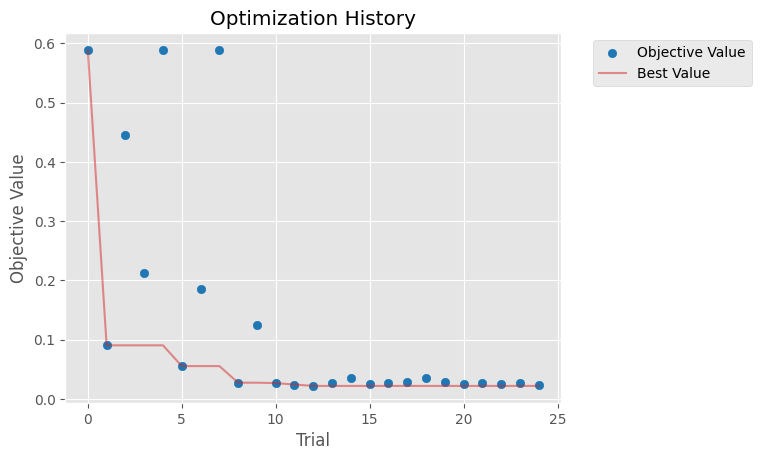

/scratch-local/nwertheim.11583483/ipykernel_3792452/380387742.py:19: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


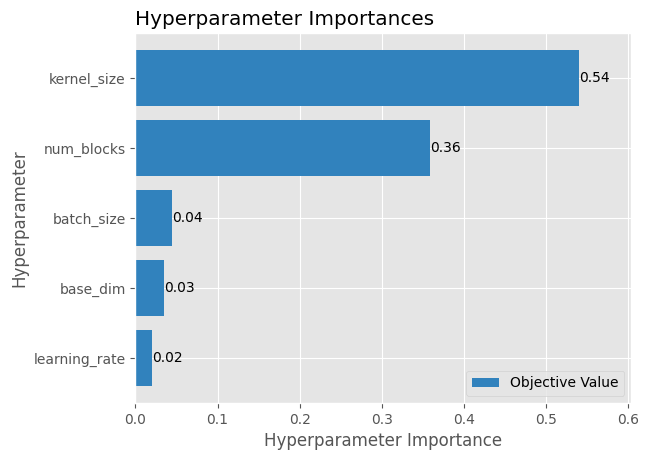

/scratch-local/nwertheim.11583483/ipykernel_3792452/380387742.py:25: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


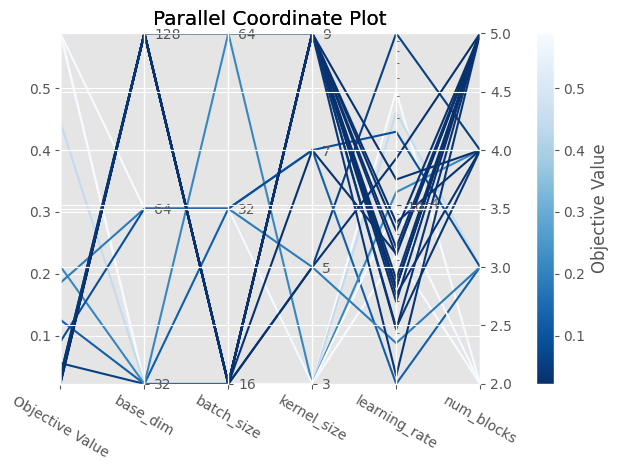

In [6]:
import os
import joblib
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
import matplotlib.pyplot as plt


path = os.path.join(models_path, 'fcmae_optuna_no_PCA_normalized_correct.pkl')
# Load the saved study
study = joblib.load(path)

# Plot: Optimization History
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
# plt.tight_layout()
plt.show()

# Plot: Hyperparameter Importance
optuna.visualization.matplotlib.plot_param_importances(study)
# plt.title("Hyperparameter Importance")
# plt.tight_layout()
plt.show()

# Plot: Parallel Coordinates (shows interaction between parameters)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.title("Parallel Coordinate Plot")
plt.tight_layout()
plt.show()
